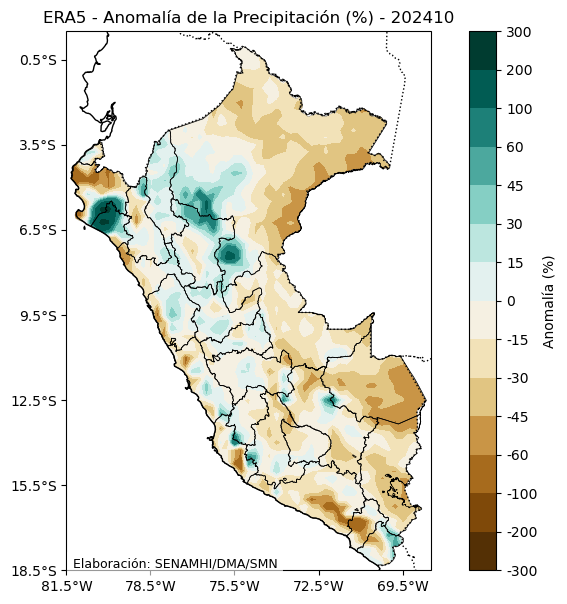

Gráfico generado con éxito.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import BoundaryNorm
import cfgrib
import xarray as xr
import geopandas as gpd
import os

# Definir constantes
FECHA_INICIAL = 202410  # Año y mes en formato YYYYMM

# Función para convertir longitudes
def convert_longitudes(lon):
    return (lon + 180) % 360 - 180

# Crear carpeta para guardar figuras
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Define las rutas a los archivos de pronóstico y climatología
ruta_pronostico = f'/scratch/DMA/SMN/CLIMA/ERA5/SURFACE/flx_era5_pp_{FECHA_INICIAL}.grib'
ruta_climatologia = '/scratch/DMA/SMN/CLIMA/ERA5/SURFACE/clima.1980-2010.nc'
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'

# Cargar los shapefiles
gdf_sudamerica_noperu = gpd.read_file(ruta_shapefile_sudamerica)
gdf_peru = gpd.read_file(ruta_shapefile_peru)

# Cargar el archivo GRIB de pronóstico
try:
    ds_pronostico = xr.open_dataset(
        ruta_pronostico,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface'}}
    )
except Exception as e:
    print(f"Error al abrir el archivo GRIB: {e}")
    raise

# Cargar el archivo NetCDF de climatología
try:
    ds_climatologia = xr.open_dataset(ruta_climatologia)
except Exception as e:
    print(f"Error al abrir el archivo NetCDF: {e}")
    raise

# Extraer la variable de precipitación del pronóstico y la climatología
variable_pronostico = ds_pronostico['tp']
variable_climatologia = ds_climatologia['tp']

# Seleccionar el mes correspondiente en climatología basado en FECHA_INICIAL
mes_pronostico = int(str(FECHA_INICIAL)[4:])
climatologia_mes = variable_climatologia.sel(time=ds_climatologia['time.month'] == mes_pronostico).mean(dim='time')

# Factor de conversión de metros a milímetros
factor_conversion = 1000

# Multiplica las variables por el factor de conversión
variable_pronostico_mm = variable_pronostico * factor_conversion
climatologia_mes_mm = climatologia_mes * factor_conversion

# Aplica la función de conversión de longitudes
variable_pronostico_mm['longitude'] = convert_longitudes(variable_pronostico_mm['longitude'])
climatologia_mes_mm['longitude'] = convert_longitudes(climatologia_mes_mm['longitude'])

# Define los límites geográficos para Perú
lon_min, lon_max = -81.5, -68.5
lat_min, lat_max = -18.5, 0.5

# Definir los niveles personalizados
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])

# Crear un colormap discreto y un norm
cmap = plt.get_cmap('BrBG', len(niveles) - 1)
norm = BoundaryNorm(niveles, cmap.N)

# Procesar datos para el único tiempo de pronóstico
dato_pronostico_peru = variable_pronostico_mm.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
climatologia_peru = climatologia_mes_mm.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Calcular la anomalía porcentual de la precipitación
anomalía_porcentual = np.where(climatologia_peru > 0,
                               ((dato_pronostico_peru - climatologia_peru) / climatologia_peru) * 100,
                               np.nan)

# Extraer la fecha del tiempo actual para el título
fecha_pronostico = ds_pronostico.valid_time.dt.strftime('%Y%m').item()

# Configurar el gráfico utilizando Cartopy
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7))

# Gráfico de la anomalía porcentual de precipitación
im = ax.contourf(dato_pronostico_peru.longitude, dato_pronostico_peru.latitude, anomalía_porcentual, 
                 levels=niveles, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Añadir shapefile de Sudamérica sin Perú
gdf_sudamerica_noperu.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.1, zorder=1)

# Añadir shapefile de los departamentos de Perú
gdf_peru.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=5)

# Añadir características adicionales
ax.add_feature(cfeature.COASTLINE, zorder=101)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=102)

# Añadir la leyenda de texto en la parte inferior derecha
ax.text(0.58, -0.0002, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=9, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Configurar el título
ax.set_title(f'ERA5 - Anomalía de la Precipitación (%) - {fecha_pronostico}')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_min, lon_max + 1, 3), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 3), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# Configurar la barra de color para mostrar solo valores enteros
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Anomalía (%)')
cbar.set_ticks(niveles)
cbar.ax.set_yticklabels([str(int(tick)) for tick in niveles])

# Crear carpeta de salida si no existe
output_dir = f'/scratch/DMA/SMN/CLIMA/web_figuras/monitoreo/mensual/'
create_folder(output_dir)

# Guardar la figura con el nombre correspondiente
output_path = f'{output_dir}era5_{fecha_pronostico}_anomPrecip_per.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()

print("Gráfico generado con éxito.")
